# Cat and Dog classification
##### In this notebook I will use CNN for this classification model and I will use two datasets from Kaggle.



So lets download the datasets

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d biaiscience/dogs-vs-cats

 99% 812M/817M [00:12<00:00, 55.0MB/s]
100% 817M/817M [00:12<00:00, 69.2MB/s]


We have to unzip them !

In [0]:
import zipfile
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
print(tf)

<module 'tensorflow' from '/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py'>


So lets download the other dataset

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 95% 257M/271M [00:03<00:00, 101MB/s] 
100% 271M/271M [00:03<00:00, 91.1MB/s]
 97% 528M/543M [00:06<00:00, 92.6MB/s]
100% 543M/543M [00:06<00:00, 90.7MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.5MB/s]


In [0]:
!mv train.zip train1.zip
!mkdir more_data
!mv train1.zip more_data

In [0]:
import zipfile
with zipfile.ZipFile("./more_data/train1.zip", 'r') as zip_ref:
    zip_ref.extractall("./more_data")

# Prepare Datasets

We have two dataset. So we should merge them and create an appropriate dataframe.

In [0]:
import os

training_dataset = []
labels = []

for x in os.listdir("./train/train/"):
    if x.startswith("dog"):
        labels.append("dog")
    else:    
        labels.append("cat")
    training_dataset.append("./train/train/" + x)

for x in os.listdir("./more_data/train/"):
    if x.startswith("dog"):
        labels.append("dog")
    else:    
        labels.append("cat")
    training_dataset.append("./more_data/train/" + x)

training_df = pd.DataFrame({
    'data': training_dataset,
    'labels': labels
})

train_df, validate_df = train_test_split(training_df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

training_df.head()

,data,labels
0,./train/train/cat.10303.jpg,cat
1,./train/train/cat.2734.jpg,cat
2,./train/train/cat.2599.jpg,cat
3,./train/train/dog.3876.jpg,dog
4,./train/train/dog.9595.jpg,dog


We will use ImageDataGenerator from Tensorflow. The main reason is images have not same size and we should force them to have same size. This module will do this for us. 

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='data',
    y_col='labels',
    target_size=(300, 300),
    batch_size=128,
    class_mode="binary"
)

validate_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='data',
    y_col='labels',
    target_size=(300, 300),
    batch_size=128,
    class_mode="binary"
)

Found 45000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Check dataset

Now lets see some images randomly with their labels.

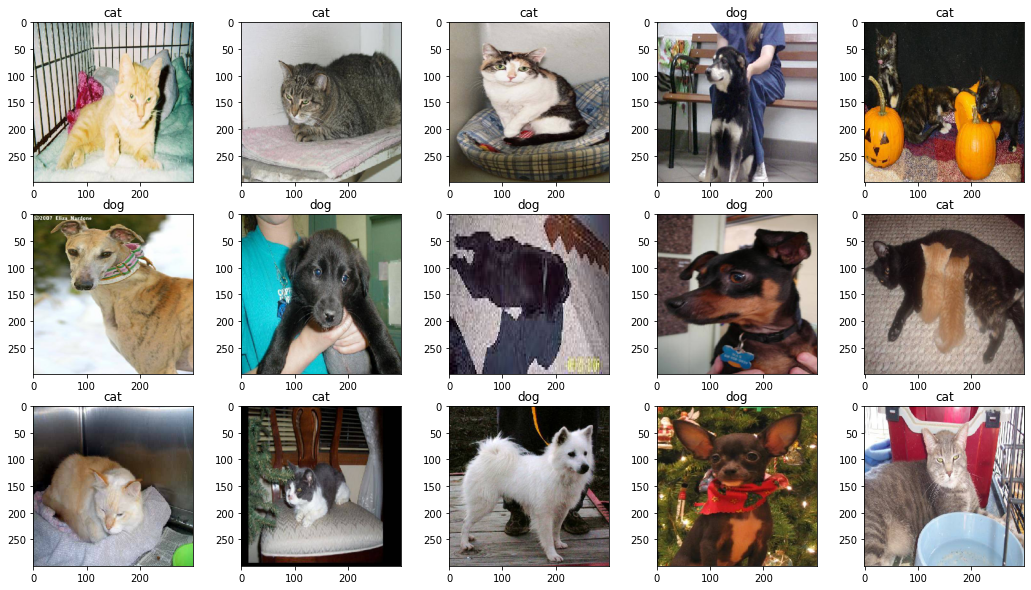

In [0]:
plt.figure(figsize=(18, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    rand = random.randrange(len(train_generator))
    second_rand = random.randrange(128)
    img = train_generator[rand][0][second_rand]
    label = train_generator[rand][1][second_rand]
    plt.title("cat" if int(label) == 0 else "dog")
    plt.imshow(img)

# Build the Model

And now this is time to create the CNN model!
We will use layers from keras.

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['mae', 'acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 147, 147, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0

In [0]:
from tensorflow.python.keras.callbacks import TerminateOnNaN, ProgbarLogger, History, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1,factor=0.2, in_lr=0.00001)
prob_logger = ProgbarLogger(count_mode='steps')
callbacks = [earlystop, learning_rate_reduction, TerminateOnNaN(), History()]

So just lets fit the model!

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs=20,
    validation_data=validate_generator,
    validation_steps=len(validate_df) // 128,
    steps_per_epoch=len(train_df) // 128,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
351/351 [==============================] - 203s 577ms/step - loss: 0.5942 - mae: 0.3319 - acc: 0.7212 - val_loss: 0.9385 - val_mae: 0.4269 - val_acc: 0.5495 - lr: 0.0010
Epoch 2/20
351/351 [==============================] - 203s 579ms/step - loss: 0.2989 - mae: 0.1812 - acc: 0.8748 - val_loss: 1.6638 - val_mae: 0.3863 - val_acc: 0.6108 - lr: 0.0010
Epoch 3/20
351/351 [==============================] - 202s 575ms/step - loss: 0.1666 - mae: 0.1005 - acc: 0.9339 - val_loss: 0.2605 - val_mae: 0.1676 - val_acc: 0.8950 - lr: 0.0010
Epoch 4/20
351/351 [==============================] - 203s 578ms/step - loss: 0.0872 - mae: 0.0534 - acc: 0.9679 - val_loss: 0.1557 - val_mae: 0.0688 - val_acc: 0.9465 - lr: 0.0010
Epoch 5/20
351/351 [==============================] - 200s 569ms/step - loss: 0.0569 - mae: 0.0337 - acc: 0.9799 - val_loss: 0.0920 - val_mae: 0.0375 - val_acc: 0.9742 - lr: 0.0010
Epoch 6/20
351/351 

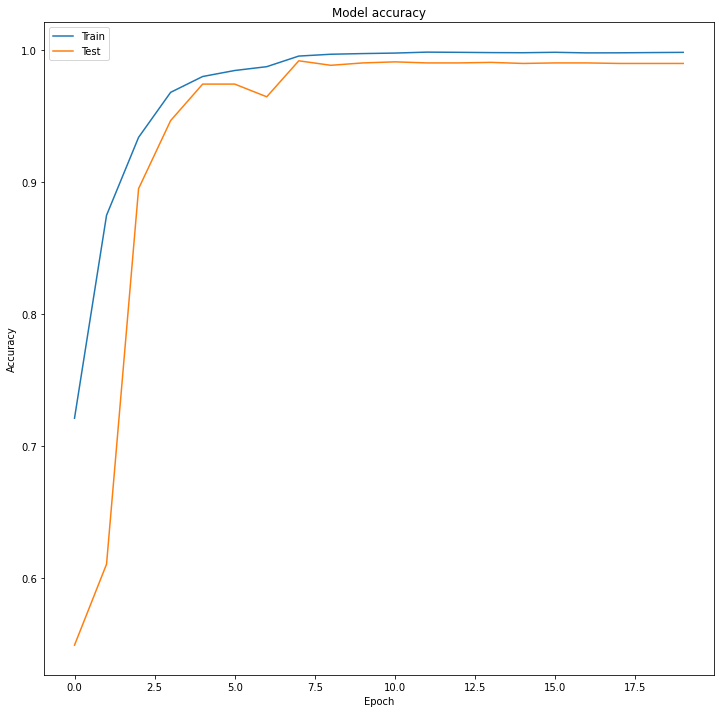

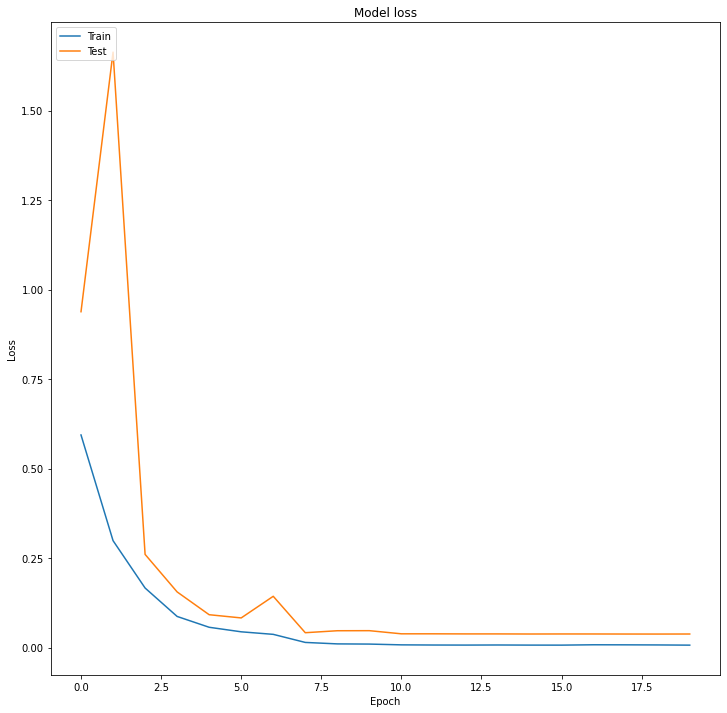

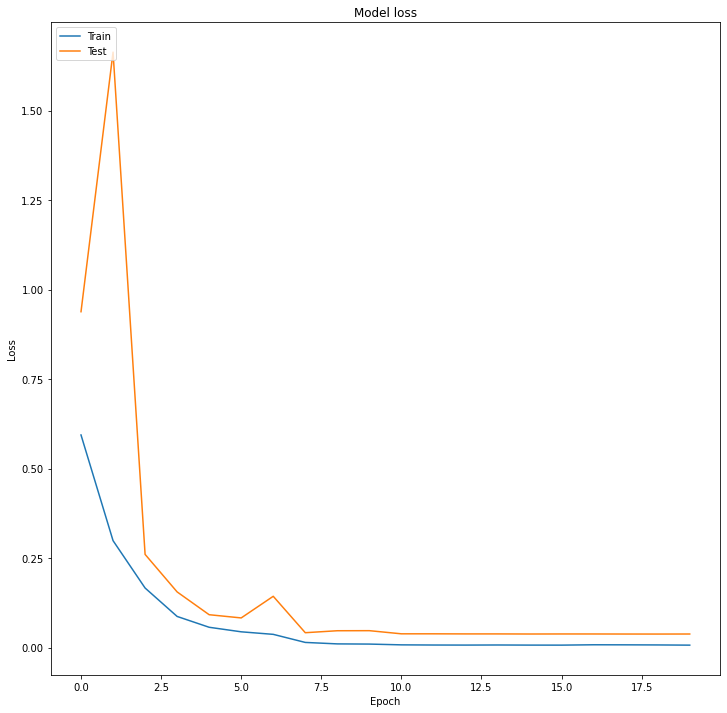

In [0]:
plt.figure(figsize=(12, 12))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Check the Model

And lets check some images and model performance

In [0]:
import zipfile
with zipfile.ZipFile("test1.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [0]:
import os
cats = []
dogs = []
testing_dataset = []
labels = []
for x in os.listdir("./test1/"):
    testing_dataset.append("./test1/" + x)

for x in os.listdir("./test/test/"):
    testing_dataset.append("./test/test/" + x)

testing_df = pd.DataFrame({
    'data': testing_dataset
})


testing_df.head()

,data
0,./test1/4684.jpg
1,./test1/622.jpg
2,./test1/2473.jpg
3,./test1/11177.jpg
4,./test1/8643.jpg


In [0]:
print(f'size of testing dataframe: {len(testing_df)}')

size of testing dataframe: 25000


In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    testing_df,
    x_col='data',
    target_size=(300, 300),
    batch_size=128,
    class_mode=None,
    shuffle=False
)

Found 25000 validated image filenames.


In [0]:
print(test_generator[0].shape, test_generator[1].shape)
print(len(test_generator))

(128, 300, 300, 3) (128, 300, 300, 3)
196


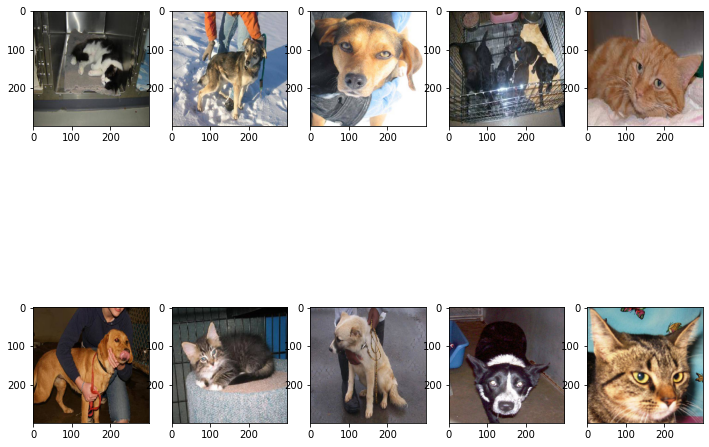

In [0]:
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    rand = random.randrange(len(test_generator))
    second_rand = random.randrange(128)
    img = test_generator[rand][second_rand]
    plt.imshow(img)

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(len(testing_df)//128))

In [0]:
predict

array([[7.0541501e-01],
       [5.4240007e-12],
       [5.8182685e-09],
       ...,
       [9.9987352e-01],
       [2.4271738e-03],
       [9.9381727e-01]], dtype=float32)

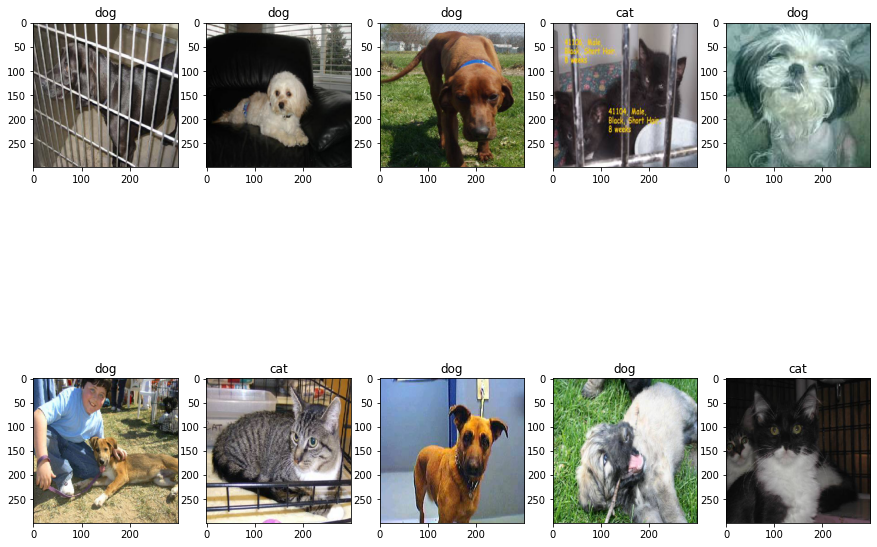

In [0]:
plt.figure(figsize=(15, 12))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = test_generator[0][10*i]
    label = predict[10*i]
    plt.title("cat" if label <= 0.5 else "dog")
    plt.imshow(img)

So as we can see out model is working well

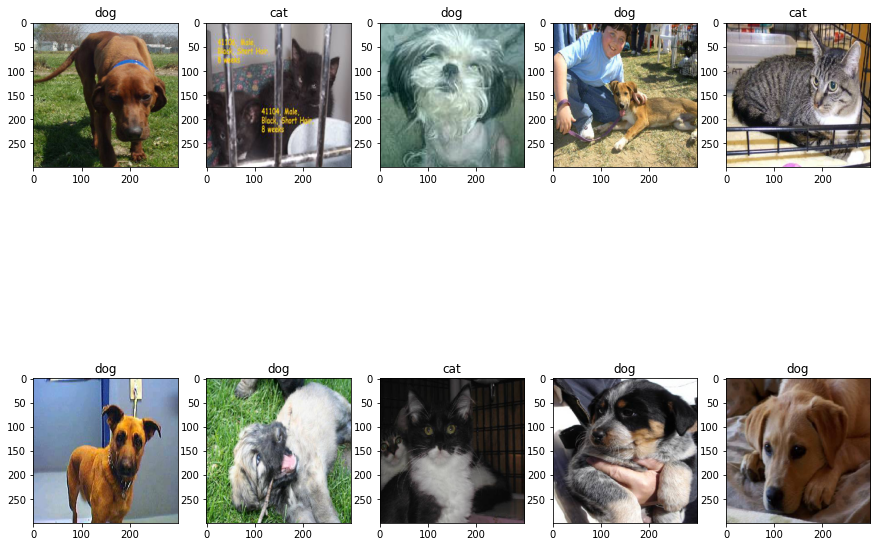

In [0]:
plt.figure(figsize=(15, 12))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = test_generator[0][10*i + 20]
    label = predict[10*i + 20]
    plt.title("cat" if label <= 0.5 else "dog")
    plt.imshow(img)

Another well result from the model. 
The rest of the notebook are some tests too.

In [0]:
import zipfile
with zipfile.ZipFile("gandom.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [0]:
import os
cats = []
dogs = []
gandom_dataset = []
labels = []
for x in os.listdir("./gandom/"):
    gandom_dataset.append("./gandom/" + x)

gandom_df = pd.DataFrame({
    'data': gandom_dataset
})


gandom_df.head()

,data
0,./gandom/1399-01-09 03.00.33.jpg
1,./gandom/1399-01-09 03.00.43.jpg
2,./gandom/1399-01-09 03.00.22.jpg
3,./gandom/1399-01-09 03.00.26.jpg
4,./gandom/1399-01-09 03.00.46.jpg


In [0]:
gandom_datagen = ImageDataGenerator(rescale=1./255)

gandom_generator = gandom_datagen.flow_from_dataframe(
    gandom_df,
    x_col='data',
    target_size=(300, 300),
    batch_size=128,
    class_mode=None,
    shuffle=False
)

Found 9 validated image filenames.


In [0]:
predict_gandom = model.predict(gandom_generator, steps=1)

In [0]:
predict_gandom

array([[9.8645407e-01],
       [1.0920515e-06],
       [8.3785197e-03],
       [9.3453890e-01],
       [2.4634744e-05],
       [9.9558395e-01],
       [7.0035364e-03],
       [4.4452745e-02],
       [1.6912104e-03]], dtype=float32)

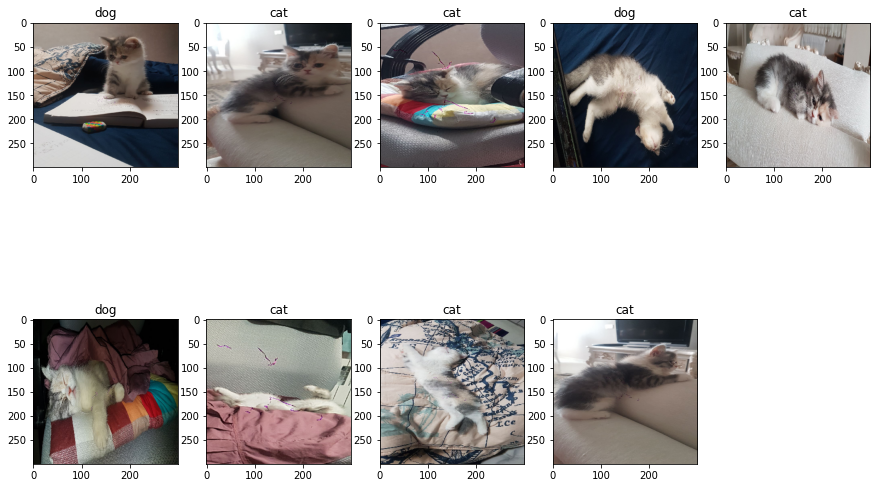

In [0]:
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(2, 5, i + 1)
    img = gandom_generator[0][i]
    label = predict_gandom[i]
    plt.title("cat" if label <= 0.5 else "dog")
    plt.imshow(img)

In [0]:
import zipfile
with zipfile.ZipFile("pinterest.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [0]:
import os

pinterest_dataset = []
labels = []
for x in os.listdir("./pinterest/"):
    pinterest_dataset.append("./pinterest/" + x)

pinterest_df = pd.DataFrame({
    'data': pinterest_dataset
})


pinterest_df.head()

,data
0,./pinterest/14 Animalitos tiernos por si esta╠...
1,./pinterest/Yakutian Laika Dog Breed Informati...
2,./pinterest/german shepherd dog puppy puppies ...
3,./pinterest/This Is what Your Favorite Dog Bre...
4,./pinterest/PREMIUM REUSABLE LINT REMOVER + Fr...


In [0]:
pinterest_datagen = ImageDataGenerator(rescale=1./255)

pinterest_generator = pinterest_datagen.flow_from_dataframe(
    pinterest_df,
    x_col='data',
    target_size=(300, 300),
    batch_size=128,
    class_mode=None,
    shuffle=False
)

Found 6 validated image filenames.


In [0]:
predict_pinterest = model.predict(pinterest_generator, steps=1)

In [0]:
predict_pinterest

array([[1.5559733e-04],
       [9.9951100e-01],
       [6.9463369e-04],
       [9.9995458e-01],
       [2.8032373e-04],
       [1.5032408e-03]], dtype=float32)

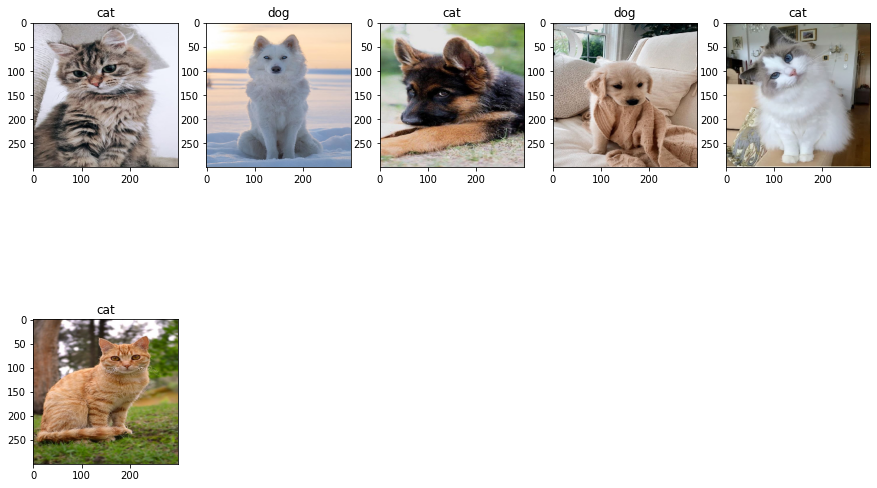

In [0]:
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 5, i + 1)
    img = pinterest_generator[0][i]
    label = predict_pinterest[i]
    plt.title("cat" if label <= 0.5 else "dog")
    plt.imshow(img)